In [ ]:
!pip install statsmodels --upgrade



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 4.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2


In [ ]:
import ee
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8B_fHfOUW0AGW6UsJ7CxIOrwKKXjRABUhCC7A8cKxnQ&tc=TsEDCBm3IdsGxi20dqo5xB0xQOEmVCrVTme-8Wcu_Ss&cc=106579MfxUnJ6qbzrYnZY80kL5D9mXJIOxFNGIWg11k

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 

In [ ]:
import datetime
import time
from math import pi, atan2, cos, sin, sqrt
import matplotlib.pyplot as plt
import ee
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
ee.Initialize()

#Bastrow: lon: -116.80747656958211   lat: 34.8968800136976
#Gobabeb: lon: 15.100674209883005     lat: -23.614010888475686
#Rooibank: lon: 14.67497468197314    lat: -23.19916172230716
#Zin:      lon: 34.7843239675769    lat: 30.74648828932832

#x = [32.718848,35.013605] #lon
#y =[32.718848,32.118848]  #LAT
#for x0, y0 in zip(x, y):
#    print(x0, y0)
lon: 34.7843239675769 
lat: 30.74648828932832

#parameter to enter
#floatLON = float(35.023605) 
#floatLAT = float(32.718848) 

floatLON = float(34.7843239675769) 
floatLAT = float(30.74648828932832) 
#------------------------------------------------------------------------------#


def smooth(TS):
    N_TS = len(TS)
    
    N = 73
    #prepare the a and b coeficiants for the TFA
    Nharmonics = 3
    a = [0., 0., 0.]
    b = [0., 0., 0.]

    for t in range(N_TS):
        for p in range(Nharmonics):
            a[p] = a[p] + (2*TS[t]*cos(2*pi*(p+1)*(t+1)/N))
            b[p] = b[p] + (2*TS[t]*sin(2*pi*(p+1)*(t+1)/N))
            
    a = [a[i]/N_TS for i in range(len(a))] 
    b = [b[i]/N_TS for i in range(len(b))] 

    #prepare the first 3 harmonics of the TFA
    H0 = sum(TS) / N_TS
    TFA = [0. for j in range(N_TS)]
    H = [[0. for k in range(N_TS)] for i in range(Nharmonics)] 
    omega = [0. for j in range(Nharmonics)]   
    Phase = [0. for j in range(Nharmonics)]    
    Amplitude = [0. for j in range(Nharmonics)]
    
    for p in range(Nharmonics):
        omega[p] = 2. * pi * (p+1) / N
        Phase[p] = atan2( -b[p], a[p] )
        Amplitude[p] = sqrt( a[p]**2 + b[p]**2 )
        for t in range(N_TS):
            H[p][t] = Amplitude[p] * cos(omega[p]*(t+1) + Phase[p])

    for t in range(N_TS):
        TFA[t] = H0 + H[0][t] + H[1][t] + H[2][t]
    
    H1 = H[0][0:73]   
    H2 = H[1][0:73]   
    H3 = H[2][0:73]   
    return TFA, H0, Amplitude, Phase, H1, H2, H3

    
    
point = {'type':'Point', 'coordinates':[ floatLON,floatLAT]};          


TS_coll_ndvi = (ee.ImageCollection('MODIS/006/MOD13Q1')
              .filterDate(datetime.datetime(2001,1, 1),
                          datetime.datetime(2021, 1, 1)))
t0 = time.time()
extract1 = TS_coll_ndvi.getRegion(point,50).getInfo();


while True:
                try:
                    extract1 = TS_coll_ndvi.getRegion(point,1).getInfo();
                    
                    break
                except:
                    print("   Resending...")
                    time.sleep(0.5)
                    
                    pass
                    #extract.pop(0) #remove first row of list ["id","longitude","latitude","time","NDVI"]

                    t1 = time.time()
                    print('elapsed time = {0} seconds'.format(t1-t0))

#TimeSeries_LST2.append(float(ftr[4]*0.02-273.15))#need to pass if get type noe
#TimeSeries_DATE2.append(int(ftr[3]))
#in the next loop we take the of the lst and also The  corresponds date
TimeSeries_DATE2 = []
TimeSeries_LST2  = []
for ftr in extract1:
       #if data is none trun the number to 99999
       for n,i in enumerate(ftr):
        print (ftr)
        if i == None:
         ftr[n] = 99999
       #print ftr
            
       try:
        
        TimeSeries_LST2.append(float(ftr[4]*0.0001))#need to pass if get type noe

        
        TimeSeries_DATE2.append(str(ftr[0]))
       except: 
        pass


#we the data from ee  to 10 list of 46 point
chunks=[TimeSeries_LST2[x:x+46] for x in range(0, len(TimeSeries_LST2), 46)]
#we trun the list into a matrix arry in order to make avg vale for each day in a year
new = np.array(chunks)
#we put no data vale on 1726.83 in order to deal with no data in the time series data from ee
#1726.83 is no data beacsoa 9999 * *0.02-273.15
noData = 1726.83
maskedvale = np.ma.masked_equal(new,noData)
print(maskedvale)
#we do mean on the matriex so we get in the end 46 point of data with no missing data
mean = maskedvale.mean(0)

#IN THIS PART WE MAKE THE interpolating TO 73 point in a time seirs  form 46 in the orginal data

N46 = range(1, 47)#range of 46 point 
y1 = mean
x = np.array(N46)
y = np.array(y1)

new_length = 73 #73 we set the range of the point we get from the interpolate to 73 
new_x = np.linspace(x.min(), x.max(), new_length)
new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)

n73fourier_vale = smooth(new_y)
LST_TFA       = n73fourier_vale[0]
LST_mean      = n73fourier_vale[1]
LST_Amplitude = n73fourier_vale[2]
LST_Phase     = n73fourier_vale[3]
H1            = n73fourier_vale[4]
H2            = n73fourier_vale[5]
H3            = n73fourier_vale[6]
print (LST_mean)
print (LST_Amplitude)
print (LST_Phase)
#we set the vale
#plot the vale after the fourier
#make range of a year

julian_date = range(0,365,5)
Ymean = np.full(73,LST_mean)
plt.plot(julian_date,new_y,'r',label='no fourier', linewidth=3)
plt.plot(julian_date,LST_TFA,'b',label='fourier',linewidth=2.8)
plt.plot(julian_date,Ymean)
plt.legend()
plt.show()

plt.plot(julian_date,H1+Ymean,'r',label='H1', linewidth=2)
plt.plot(julian_date,H2+Ymean,'b',label='H2', linewidth=2)
plt.plot(julian_date,H3+Ymean,'g',label='H3', linewidth=2)
plt.plot(julian_date,Ymean)
plt.legend()
plt.show()
print(len(TimeSeries_LST2))

EEException: ignored

In [ ]:
date_list =[]
for date in TimeSeries_DATE2:
  
 date_list.append(datetime.datetime.strptime(str(date[0:4])+str(date[5:7])+str(date[8:10]), '%Y%m%d'))

print(date_list)
len(date_list)


[datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2001, 1, 17, 0, 0), datetime.datetime(2001, 2, 2, 0, 0), datetime.datetime(2001, 2, 18, 0, 0), datetime.datetime(2001, 3, 6, 0, 0), datetime.datetime(2001, 3, 22, 0, 0), datetime.datetime(2001, 4, 7, 0, 0), datetime.datetime(2001, 4, 23, 0, 0), datetime.datetime(2001, 5, 9, 0, 0), datetime.datetime(2001, 5, 25, 0, 0), datetime.datetime(2001, 6, 10, 0, 0), datetime.datetime(2001, 6, 26, 0, 0), datetime.datetime(2001, 7, 12, 0, 0), datetime.datetime(2001, 7, 28, 0, 0), datetime.datetime(2001, 8, 13, 0, 0), datetime.datetime(2001, 8, 29, 0, 0), datetime.datetime(2001, 9, 14, 0, 0), datetime.datetime(2001, 9, 30, 0, 0), datetime.datetime(2001, 10, 16, 0, 0), datetime.datetime(2001, 11, 1, 0, 0), datetime.datetime(2001, 11, 17, 0, 0), datetime.datetime(2001, 12, 3, 0, 0), datetime.datetime(2001, 12, 19, 0, 0), datetime.datetime(2002, 1, 1, 0, 0), datetime.datetime(2002, 1, 17, 0, 0), datetime.datetime(2002, 2, 2, 0, 0), datetime.dateti

460

,NDVI
DATE,
2020-10-15,0.1076
2020-10-31,0.1104
2020-11-16,0.1027
2020-12-02,0.1108
2020-12-18,0.1102


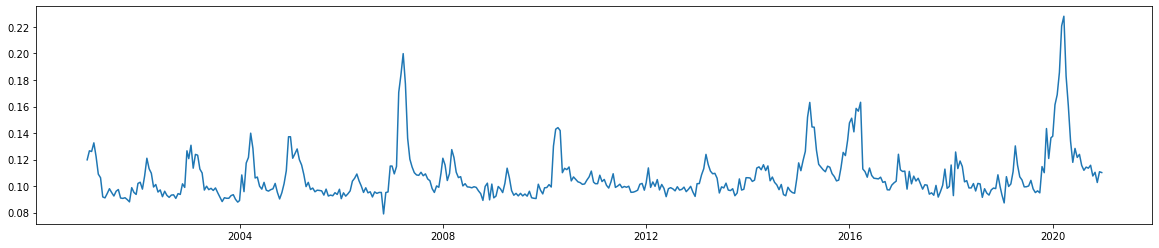

In [ ]:
import matplotlib.pyplot as plt
# dictionary of lists 
dict = {'DATE': date_list, 'NDVI': TimeSeries_LST2} 
    
df = pd.DataFrame(dict)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)    
plt.figure(figsize=(20,4))
plt.plot(df['NDVI'])
df.tail()

In [ ]:
df

,NDVI
DATE,
2001-01-01,0.1198
2001-01-17,0.1266
2001-02-02,0.1261
2001-02-18,0.1326
2001-03-06,0.1223
...,...
2020-10-15,0.1076
2020-10-31,0.1104
2020-11-16,0.1027


In [ ]:


#import matplotlib.pyplot as plt
#import pandas as pd
#import seaborn as sns
#from pandas.plotting import register_matplotlib_converters
#import statsmodels
#from statsmodels.tsa.seasonal import STL

#stl = STL(df,seasonal = 23, period =69)
#res = stl.fit()
#fig = res.plot()



In [ ]:
#df['less_trend'] = df['NDVI'] - res.trend
#df.plot()



In [ ]:
#df_less = df.drop(columns='NDVI')
#df_less.plot()
#print(len(df_less['less_trend']))
#df_less.head()



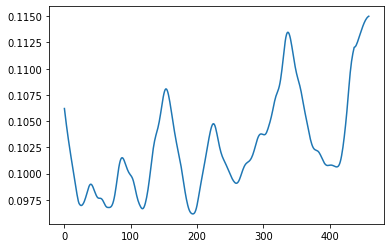

In [ ]:
import statsmodels.api as sm
df['index'] = df.index
y = df['NDVI'].tolist()
x = df["index"].tolist()
n=len(df)
x = list(range(0,n))
lowess = sm.nonparametric.lowess(y, x, frac=.1)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

plt.plot(lowess_x, lowess_y)

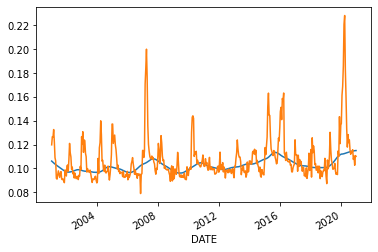

In [ ]:
df['NDVI_lowess'] = lowess_y
#df_less = df_less.drop(columns='less_trend')
df['NDVI_lowess'].plot()
df['NDVI'].plot()



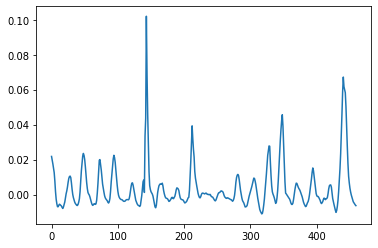

In [ ]:
df['NDVI_less_trend'] = df['NDVI'] - df['NDVI_lowess']
y2 = df['NDVI_less_trend'].tolist()
x2 = df["index"].tolist()
n=len(df)
x2 = list(range(0,n))
lowess = sm.nonparametric.lowess(y2, x2, frac=.02)
lowess_x2 = list(zip(*lowess))[0]
lowess_y2 = list(zip(*lowess))[1]

plt.plot(lowess_x2, lowess_y2)

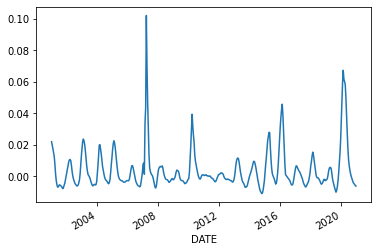

In [ ]:
df['NDVI_less_trend'] = lowess_y2
df['NDVI_less_trend'].plot()

In [ ]:

# Python3 code to demonstrate working of
# Convert date range to N equal durations
# Using loop
import datetime
  
# initializing dates
test_date1 = datetime.datetime(2001, 1, 1)
test_date2 = datetime.datetime(2022, 1, 1)
               
# printing original dates
print("The original date 1 is : " + str(test_date1))
print("The original date 2 is : " + str(test_date2))
  
# initializing N
#N = 460
#N = 730  
N = 1460
#N = 9200
temp = []
  
# getting diff.
diff = ( test_date2 - test_date1) // N
for idx in range(0, N):
      
    # computing new dates
    temp.append((test_date1 + idx * diff))
  
# using strftime to convert to userfriendly 
# format
res = []
for sub in temp:
  #res.append(sub.strftime("%Y/%m/%d %H:%M:%S"))
  res.append(sub.strftime("%Y/%m/%d"))
  
# printing result
print("N equal duration dates : " + str(res))
#https://www.ianwootten.co.uk/2014/07/01/splitting-a-date-range-in-python/
#https://miguendes.me/how-to-use-datetimetimedelta-in-python-with-examples
len(res)

The original date 1 is : 2001-01-01 00:00:00
The original date 2 is : 2022-01-01 00:00:00
N equal duration dates : ['2001/01/01', '2001/01/06', '2001/01/11', '2001/01/16', '2001/01/22', '2001/01/27', '2001/02/01', '2001/02/06', '2001/02/12', '2001/02/17', '2001/02/22', '2001/02/27', '2001/03/05', '2001/03/10', '2001/03/15', '2001/03/20', '2001/03/26', '2001/03/31', '2001/04/05', '2001/04/10', '2001/04/16', '2001/04/21', '2001/04/26', '2001/05/01', '2001/05/07', '2001/05/12', '2001/05/17', '2001/05/22', '2001/05/28', '2001/06/02', '2001/06/07', '2001/06/12', '2001/06/18', '2001/06/23', '2001/06/28', '2001/07/03', '2001/07/09', '2001/07/14', '2001/07/19', '2001/07/24', '2001/07/30', '2001/08/04', '2001/08/09', '2001/08/14', '2001/08/20', '2001/08/25', '2001/08/30', '2001/09/04', '2001/09/10', '2001/09/15', '2001/09/20', '2001/09/25', '2001/10/01', '2001/10/06', '2001/10/11', '2001/10/16', '2001/10/22', '2001/10/27', '2001/11/01', '2001/11/06', '2001/11/12', '2001/11/17', '2001/11/22', '2

1460

In [ ]:
date_list_for_N73 =[]
for date in res:
  
 date_list_for_N73.append(datetime.datetime.strptime(str(date[0:4])+str(date[5:7])+str(date[8:10]), '%Y%m%d'))

print(date_list_for_N73)
len(date_list_for_N73)

[datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2001, 1, 6, 0, 0), datetime.datetime(2001, 1, 11, 0, 0), datetime.datetime(2001, 1, 16, 0, 0), datetime.datetime(2001, 1, 22, 0, 0), datetime.datetime(2001, 1, 27, 0, 0), datetime.datetime(2001, 2, 1, 0, 0), datetime.datetime(2001, 2, 6, 0, 0), datetime.datetime(2001, 2, 12, 0, 0), datetime.datetime(2001, 2, 17, 0, 0), datetime.datetime(2001, 2, 22, 0, 0), datetime.datetime(2001, 2, 27, 0, 0), datetime.datetime(2001, 3, 5, 0, 0), datetime.datetime(2001, 3, 10, 0, 0), datetime.datetime(2001, 3, 15, 0, 0), datetime.datetime(2001, 3, 20, 0, 0), datetime.datetime(2001, 3, 26, 0, 0), datetime.datetime(2001, 3, 31, 0, 0), datetime.datetime(2001, 4, 5, 0, 0), datetime.datetime(2001, 4, 10, 0, 0), datetime.datetime(2001, 4, 16, 0, 0), datetime.datetime(2001, 4, 21, 0, 0), datetime.datetime(2001, 4, 26, 0, 0), datetime.datetime(2001, 5, 1, 0, 0), datetime.datetime(2001, 5, 7, 0, 0), datetime.datetime(2001, 5, 12, 0, 0), datetime.datetime(2

1460

In [ ]:
print(list(df['NDVI_less_trend']))
print(len(df['NDVI_less_trend']))

[0.021808064108479963, 0.01981055094497235, 0.017544975232791818, 0.015147105743417556, 0.012560428921403277, 0.007697048924249494, 0.0016128738970767093, -0.0027148734105638334, -0.005299189542492546, -0.006944102039061752, -0.006921484792786238, -0.00602035846676744, -0.005507168647880065, -0.0058181402867782, -0.0062441074213015774, -0.006588542962096516, -0.00739781865819169, -0.007950951024997906, -0.007030079226112598, -0.005672131993823363, -0.0041991237721738335, -0.0018812194622225737, 0.0004839063974942651, 0.00212450180465776, 0.004316164509388759, 0.007001820014163861, 0.009202856447744778, 0.010294907060951377, 0.010573469054412027, 0.009730017271639394, 0.006634879660284122, 0.002955486248526328, 9.913201277025345e-06, -0.0018029626738813138, -0.0032115769202900545, -0.004386190748122606, -0.005141810623528046, -0.005628127135530635, -0.006155162904884025, -0.006226041369963804, -0.005598790745060302, -0.004298176216337885, -0.0024046427664919582, 0.0015953866839440065, 0

In [ ]:
import math
to_forier = list(df['NDVI_less_trend'])
for i in to_forier:
  if math.isnan(i) == True:
    to_forier[i] = 0.04409690393354137
  else:
    continue 


#we the data from ee  to 10 list of 46 point
chunks=[to_forier[x:x+46] for x in range(0, len(to_forier), 46)]
#we trun the list into a matrix arry in order to make avg vale for each day in a year
new = np.array(chunks)
#we put no data vale on 1726.83 in order to deal with no data in the time series data from ee
#1726.83 is no data beacsoa 9999 * *0.02-273.15
noData = 1726.83
maskedvale = np.ma.masked_equal(new,noData)
#we do mean on the matriex so we get in the end 46 point of data with no missing data
mean = maskedvale.mean(0)

#IN THIS PART WE MAKE THE interpolating TO 73 point in a time seirs  form 46 in the orginal data

N46 = range(1, 47)#range of 46 point 
y1 = mean
x = np.array(N46)
y = np.array(y1)

new_length = 73 #73 we set the range of the point we get from the interpolate to 73 
new_x = np.linspace(x.min(), x.max(), new_length)
new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)

n73fourier_vale = smooth(new_y)
LST_TFA       = n73fourier_vale[0]
print(LST_TFA)

[0.006025635204677574, 0.007569602883616093, 0.008981227183845504, 0.010216779981948178, 0.011237472684630738, 0.012010643095712425, 0.01251079100070784, 0.012720427913320039, 0.012630710090727162, 0.012241828878846395, 0.011563138645521944, 0.010613009881294488, 0.009418403307423594, 0.008014169776912954, 0.006442090076582253, 0.0047496780814422525, 0.0029887796918001077, 0.001214008202607273, -0.0005189361731988036, -0.0021550093367367364, -0.003641571840449897, -0.0049300841672543115, -0.005977690474071831, -0.006748635264268139, -0.0072154624067992295, -0.007359952936463404, -0.007173766903005034, -0.006658764851664297, -0.005826995904980674, -0.004700351411237137, -0.0033098952321733363, -0.0016948934562002825, 9.84228458678622e-05, 0.0020183187067183165, 0.004009189294605948, 0.006013310242546142, 0.00797264411041741, 0.009830641647636256, 0.011533977704535422, 0.01303416506615383, 0.014288994951953158, 0.015263760153282326, 0.015932225413311372, 0.01627731928933472, 0.0162915319

In [ ]:
LST_TFA_20_Y = LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA

In [ ]:
#LST_TFA_10_Y = LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA+LST_TFA

In [ ]:
print(LST_TFA_20_Y)

[0.006025635204677574, 0.007569602883616093, 0.008981227183845504, 0.010216779981948178, 0.011237472684630738, 0.012010643095712425, 0.01251079100070784, 0.012720427913320039, 0.012630710090727162, 0.012241828878846395, 0.011563138645521944, 0.010613009881294488, 0.009418403307423594, 0.008014169776912954, 0.006442090076582253, 0.0047496780814422525, 0.0029887796918001077, 0.001214008202607273, -0.0005189361731988036, -0.0021550093367367364, -0.003641571840449897, -0.0049300841672543115, -0.005977690474071831, -0.006748635264268139, -0.0072154624067992295, -0.007359952936463404, -0.007173766903005034, -0.006658764851664297, -0.005826995904980674, -0.004700351411237137, -0.0033098952321733363, -0.0016948934562002825, 9.84228458678622e-05, 0.0020183187067183165, 0.004009189294605948, 0.006013310242546142, 0.00797264411041741, 0.009830641647636256, 0.011533977704535422, 0.01303416506615383, 0.014288994951953158, 0.015263760153282326, 0.015932225413311372, 0.01627731928933472, 0.0162915319

In [ ]:
print(len(LST_TFA_20_Y))
print(len(date_list_for_N73))
print(len(LST_TFA))

1460
1460
73


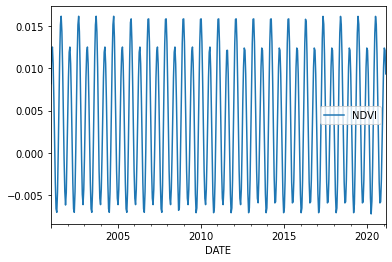

In [ ]:
# dictionary of lists 
dict = {'DATE': date_list_for_N73, 'NDVI': LST_TFA_20_Y, } 
    
df_f = pd.DataFrame(dict)
df_f['DATE'] = pd.to_datetime(df_f['DATE'])

df_f.set_index('DATE', inplace=True) 
df_f = df_f.resample('16D').mean() 
df_f = df_f[:460]
df_f.plot()
#df_less_smooth.plot()


In [ ]:
print(len(df))
print(len(df_f))

460
460


In [ ]:
pd.set_option('display.max_rows', None)
df['fourier'] = df_f['NDVI']
k=0
for i in df['NDVI']:
  df['fourier'][k] = df_f['NDVI'][k]
  k+=1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


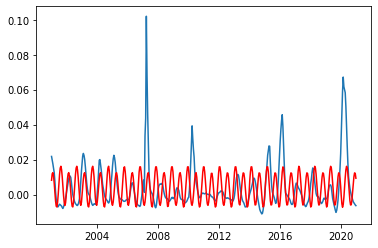

In [ ]:
import matplotlib
matplotlib.pyplot.plot(df['NDVI_less_trend'])
matplotlib.pyplot.plot(df['fourier'],color='red')
matplotlib.pyplot.show()

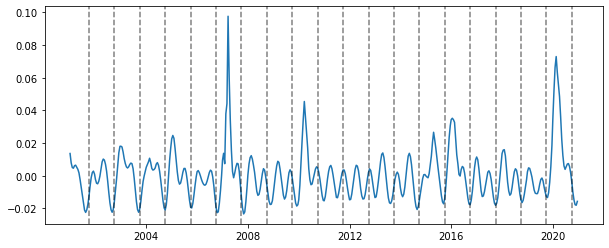

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
df['area'] = df['NDVI_less_trend'] - df['fourier']
plt.figure(figsize=(10,4))
plt.plot(df['area'])
for year in range(2001,2021):
  plt.axvline(datetime(year,10,1), color='k', linestyle='--', alpha=0.5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'NDVI')

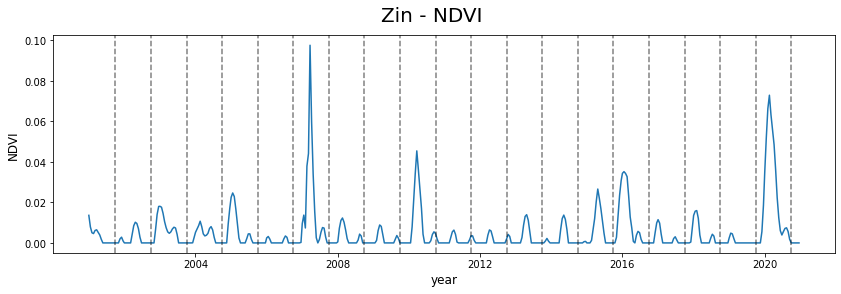

In [ ]:
k=0
for i in df['area']:
  if i<=0 :
    df['area'][k]=0
    k+=1  
  elif i>0:
    k+=1
    
plt.figure(figsize=(14,4))
plt.plot(df['area'])
for year in range(2001,2021):
  plt.axvline(datetime(year,10,1), color='k', linestyle='--', alpha=0.5)
plt.suptitle('Zin - NDVI',fontsize=20) 
plt.xlabel("year",fontsize=12)
plt.ylabel("NDVI",fontsize=12)

In [ ]:

from scipy.integrate import simps
import numpy as np
dict_integrate = {}
for year in range(2000,2021):
  slice = df['area'][(datetime(year,10,1)):(datetime(year+1,10,1))]
  y = np.array(slice)
  I = simps(y,dx=12)
  dict_integrate[(year+1)] = I
  print((I))

0.568345619961866
0.5752302989292052
1.7760261466096643
0.9904101695572354
1.6725850991980256
0.18817577013934167
3.968324635274068
0.6995095644599272
0.4371234130064325
2.464489551725166
0.2746572572842514
0.27269114420400875
0.726852905583111
0.6680835340559902
1.463272469658233
3.2055747061401503
0.5745767841247521
0.9409518458750196
0.16647139951879647
6.30237497310788
0.0


In [ ]:
x = list(dict_integrate.keys())
print(x)
y = list(dict_integrate.values())
print (y)

[2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
[0.568345619961866, 0.5752302989292052, 1.7760261466096643, 0.9904101695572354, 1.6725850991980256, 0.18817577013934167, 3.968324635274068, 0.6995095644599272, 0.4371234130064325, 2.464489551725166, 0.2746572572842514, 0.27269114420400875, 0.726852905583111, 0.6680835340559902, 1.463272469658233, 3.2055747061401503, 0.5745767841247521, 0.9409518458750196, 0.16647139951879647, 6.30237497310788, 0.0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Text(0.5, 0.98, 'MODIS - Zin')

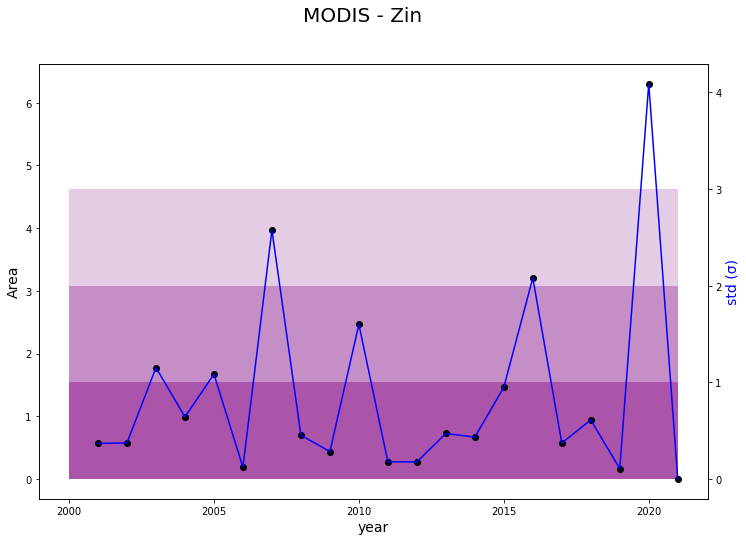

In [ ]:
df_integrate = pd.DataFrame()
df_integrate['year'] = list(dict_integrate.keys())
df_integrate['area'] = list(dict_integrate.values())
dev = df_integrate['area'].std()
df_integrate['std'] = 0.56

k=0
for i in df_integrate['area']:
  df_integrate['std'][k] = (i/dev)
  k+=1

x = list(dict_integrate.keys())
y = list(dict_integrate.values())
y2 = list(df_integrate['std'])


fig, ax = plt.subplots(figsize=(12,8))

ax.fill_between(range(2000,2022), dev, facecolor = "purple", alpha=0.4, linestyle='--', linewidth=2)
ax.fill_between(range(2000,2022), dev*2, facecolor = "purple", alpha=0.3, linestyle='--', linewidth=2)
ax.fill_between(range(2000,2022), dev*3, facecolor = "purple", alpha=0.2, linestyle='--', linewidth=2)

ax.scatter(x, y, color = 'black')
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("Area", fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, y2 ,color="blue" )
ax2.set_ylabel("std (\u03C3)",color="blue",fontsize=14)
fig.suptitle('MODIS - Zin',fontsize=20) 

In [ ]:
#downloading the df_integrate
from google.colab import files
df_integrate.to_csv('zin_mod_fourier.csv') 
files.download('zin_mod_fourier.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>